In [1]:
import sys
sys.path.append("..")
from crowd_sim.envs.utils.action import ActionRot
from env_setup import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from math import pi
import torch
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical
from multiprocessing_env import SubprocVecEnv
import time
import numpy as np

In [2]:
class Reward_counter() :
    def __init__(self, n_workers) :
        self.n_workers = n_workers
        self.reset()
        
    def reset(self) :
        self.reward_log = [[] for i in range(self.n_workers)]
        self.acc_reward = np.zeros(self.n_workers)
        self.acc_dones = np.zeros(self.n_workers)
        
    def update(self, rewards, dones) :
        for i, (r, done) in enumerate(zip(rewards, dones)) :
            self.update_worker(i, r, done)
            
    def update_worker(self, i, reward, done) :
        self.acc_reward[i] += reward
        if done : 
            self.reward_log[i].append(self.acc_reward[i])
            self.acc_reward[i] = 0
            self.acc_dones[i] += 1
        
    def plot_results(self, conv=100) :
        plt.title('Reward avg per workers over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward avg')
        for i in range(self.n_workers) :
            rew_worker = rewards_avg = np.convolve(self.reward_log[i], np.ones((conv,))/conv, mode='valid')
            plt.plot(rew_worker, label=f'worker {i}')
        plt.show()
        for i in range(self.n_workers) :
            print('Worker {} did {} full sims'.format(i, self.acc_dones[i]))

In [3]:
def batch_iter(advantage, ob_states, actions, log_probs, returns, n_steps, batch_size=4) :
    for i in range(n_steps // batch_size) :
        idxs = np.random.permutation(range(n_steps))[:batch_size]
        yield advantage[idxs], ob_states[idxs], actions[idxs], log_probs[idxs], returns[idxs], idxs

In [13]:
def clipped_action(action) :
    return ActionRot(1, np.clip(action.r, 0, 2*pi))

In [14]:
def ppo_train(actor_critic, enviorements, n_workers, n_episodes = 100, lr = 1e-3, 
              gamma = 0.99, n_steps = 16, eps = 0.25, batch_size = 4, n_epochs = 2,
              reward_counter=None, show_result=10, device='cpu', n_humans=5, st_size=14, print_time=False) :
    
    opt = Adam(actor_critic.model.parameters(), lr=lr)
    reward_counter = Reward_counter(n_workers) if reward_counter is None else reward_counter
    
    for i in tqdm_notebook(range(n_episodes)) :

        rewards = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        mask = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        log_probs = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        values = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        actions = torch.zeros((n_steps, n_workers, 2), dtype=torch.float).to(device)
        ob_states = torch.zeros((n_steps, n_workers, n_humans, st_size), dtype=torch.float).to(device)


        if i == 0 :
            observations = enviorements.reset()

        step = 0
        if print_time :
            print('Starting episode {}'.format(i))
        time_start_ep = time.time() 
        while step < n_steps :

            vals, dist = actor_critic.predict(observations, update_time=True)
            
            ob_states[step] = torch.tensor(observations, dtype=torch.float32, device=device)
            values[step] = vals.view(-1)

            #choose action
            acts = dist.sample()
            log_probs[step] = dist.log_prob(acts)
            actions[step] = acts
            
            action_clipped = [clipped_action(ActionRot(acts[i, 0], acts[i, 1])) for i in range(n_workers)]

            obs, r, dones, _ = enviorements.step(action_clipped)
            mask[step] = torch.tensor(1-dones).to(device)
            rewards[step] = torch.from_numpy(r)

            observations = obs

            reward_counter.update(r, dones)
            step+=1      
        time_end_simu = time.time()

        #discounted returns calculation (with bootstraping)
        returns = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        with torch.no_grad() :
            q_val, _ = actor_critic.predict(observations)
        q_val = q_val.view(-1).detach()
        for i in reversed(range(n_steps)) :
            q_val = rewards[i] + gamma * q_val * (mask[i])
            returns[i] = q_val
        advantage = (returns - values).detach()
        
        time_start_opt = time.time()
        #optimization
        for epoch in range(n_epochs) :
            a = 0
            for adv_b, state_b, action_b, l_probs_b, returns_b, idxs in batch_iter(advantage, ob_states, actions, 
                                                                                   log_probs, returns.detach(), n_steps=n_steps, batch_size=batch_size) :

                vals, dist = actor_critic.predict(state_b.view(-1, n_humans, st_size).numpy())
                
                #new_actor_probs = (dist_theta.log_prob(action_b[:, :, 1].view(-1)) * dist_vel.log_prob(action_b[:, :, 0].view(-1))).view(batch_size, n_workers)
                s1, s2, _ = action_b.shape
                new_actor_probs = dist.log_prob(action_b.view(-1, 2)).view(s1, s2, -1)
                entropy = dist.entropy().mean()
                
                #probability ration and clipped prob ration
                r = torch.exp((new_actor_probs) - (l_probs_b.detach()))
                clipped_r = torch.clamp(r, 1-eps, 1+eps)
                adv = returns_b.view(batch_size, n_workers, -1) - vals.view(batch_size, n_workers, 1)

                #critic loss
                critic_loss = adv.pow(2).mean()

                #actor loss
                clipped_loss = clipped_r * adv_b.detach()
                loss_ = r * adv_b.detach()
                actor_loss = -torch.min(clipped_loss, loss_).mean()

                opt.zero_grad()
                loss = 0.5 * (critic_loss + actor_loss) 
                loss.backward()
                opt.step()
        
        time_end_ep = time.time()
        time_epiode = time_end_ep - time_start_ep
        time_opti = time_end_ep - time_start_opt
        time_simu = time_end_simu - time_start_ep
        
        if print_time :
            print('Episode {} took {:.2f}s, {:.2f}s simu, {:.2f}s opti'.format(i, time_epiode, time_simu, time_opti))
        
    if show_result is not None :
        reward_counter.plot_results(conv=show_result)
        
    return actor_critic, reward_counter
    

In [15]:
ac_policy = gen_policy()
envs = gen_multi_envs(4, ac_policy)

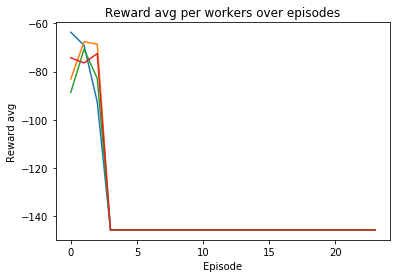

Worker 0 did 24.0 full sims
Worker 1 did 24.0 full sims
Worker 2 did 24.0 full sims
Worker 3 did 24.0 full sims


In [16]:
ac_policy, rc = ppo_train(ac_policy, envs, 4, n_episodes=150 , show_result=1)

In [60]:
import sys
sys.path.append("..")
from crowd_sim.envs.utils.action import ActionRot
from env_setup import *
from crowd_sim_ppo import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from math import pi
import torch
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical
from multiprocessing_env import SubprocVecEnv
import time

In [8]:
env = gen_env(ac_policy)

In [9]:
def render_random_ep(enviorement, plolicy=None) :
    enviorement.reset() 
    while True  :
        act = ActionRot(1, 2 * np.pi)
        ob, r, done, _ = enviorement.step(act)
        if done :
            break
    enviorement.render(mode='traj')

In [10]:
def render_policy_ep(enviorement, policy) :
    ob = enviorement.reset() 
    while True  :
        val, dist = policy.predict(np.asarray([ob]))
        acts = dist.sample()
        
            
        action_clipped = clipped_action(ActionRot(acts[0, 0], acts[0, 1]))
        print(acts, action_clipped)

        ob, r, done, _ = enviorement.step(action_clipped)
        if done :
            break
    enviorement.render(mode='traj')

In [17]:
ac_policy.model.dist_mean, ac_policy.model.dist_std

(tensor([[4.2927, 2.4317],
         [4.2926, 2.4318],
         [4.2929, 2.4312],
         [4.2914, 2.4332],
         [4.2923, 2.4321],
         [4.2931, 2.4313],
         [4.2936, 2.4304],
         [4.2923, 2.4322],
         [4.2924, 2.4320],
         [4.2928, 2.4315],
         [4.2936, 2.4304],
         [4.2921, 2.4325],
         [4.2920, 2.4326],
         [4.2931, 2.4313],
         [4.2937, 2.4303],
         [4.2924, 2.4321]], grad_fn=<AddmmBackward>), 0.18143590657882502)

tensor([[3.8298, 2.4036]]) ActionRot(v=1, r=tensor(2.4036))
tensor([[3.6132, 2.5334]]) ActionRot(v=1, r=tensor(2.5334))
tensor([[4.2282, 2.0527]]) ActionRot(v=1, r=tensor(2.0527))
tensor([[4.1194, 2.1706]]) ActionRot(v=1, r=tensor(2.1706))
tensor([[3.6905, 3.0923]]) ActionRot(v=1, r=tensor(3.0923))
tensor([[4.5960, 2.2194]]) ActionRot(v=1, r=tensor(2.2194))
tensor([[4.5961, 2.5158]]) ActionRot(v=1, r=tensor(2.5158))
tensor([[4.2264, 2.1194]]) ActionRot(v=1, r=tensor(2.1194))
tensor([[4.0009, 3.2476]]) ActionRot(v=1, r=tensor(3.2476))
tensor([[3.9448, 2.7859]]) ActionRot(v=1, r=tensor(2.7859))
tensor([[3.9303, 2.7470]]) ActionRot(v=1, r=tensor(2.7470))
tensor([[3.6672, 2.6171]]) ActionRot(v=1, r=tensor(2.6171))
tensor([[4.2915, 2.7410]]) ActionRot(v=1, r=tensor(2.7410))
tensor([[3.9301, 2.5295]]) ActionRot(v=1, r=tensor(2.5295))
tensor([[4.2330, 2.8511]]) ActionRot(v=1, r=tensor(2.8511))
tensor([[4.1927, 2.8530]]) ActionRot(v=1, r=tensor(2.8530))
tensor([[3.7551, 2.3563]]) ActionRot(v=1

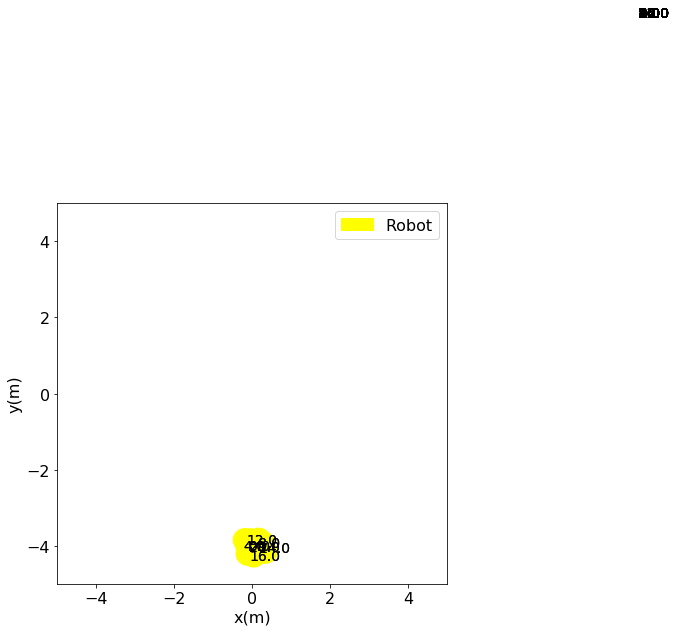

In [18]:
render_policy_ep(env, ac_policy)

In [5]:
x,y = ac_policy.predict(np.asarray([ob]))

In [6]:
x

(tensor([[0.0142]], grad_fn=<AddmmBackward>),
 Normal(loc: tensor([-0.0063], grad_fn=<SelectBackward>), scale: tensor([1.0192], grad_fn=<SelectBackward>)),
 Normal(loc: tensor([0.1188], grad_fn=<SelectBackward>), scale: tensor([1.0146], grad_fn=<SelectBackward>)))

In [7]:
y

tensor([[[ 2.0000,  1.0000,  0.0000,  0.3000,  0.0000,  0.0000,  4.2722,
          -3.9402,  0.0000,  0.0000,  0.3000,  5.8117,  0.6000]]])

In [8]:
env.humans[1].py

-4.0

In [15]:
np.ones_like(np.random.randint(1, 2, 3)) * 0.1

array([0.1, 0.1, 0.1])

In [16]:
from torch.distributions import MultivariateNormal

In [6]:
a = torch.randn(4, 4, 2)

In [51]:
d = MultivariateNormal(a, torch.eye(2).expand(4, 4, 2, 2))

In [41]:
d.sample().shap

torch.Size([4, 4, 2])

In [42]:
d.log_prob(torch.randn(4, 2))

tensor([[-12.3153,  -4.6237,  -3.9401,  -3.3161],
        [ -7.7634,  -7.7194,  -2.2219,  -2.5437],
        [ -5.1548,  -3.6816,  -6.0102,  -3.5677],
        [ -6.8460,  -4.4097,  -3.1474,  -2.7057]])